# Previsão de Custos Médicos
Este notebook visa testar múltiplos modelos de regressão para identificar o melhor para prever encargos médicos individuais.

## 1. Exploração de Dados
Carregamos o dataset e ajustamos as colunas para visualizá-las corretamente.

In [4]:
# Carregar bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

In [5]:
# Carregar o dataset
dataset = pd.read_csv('dados_custos.csv', delimiter=';')
dataset.head()

,idade,gênero,imc,filhos,fumante,região,encargos
0,18,feminino,31.956701,3,não,norte,22782.353880
1,27,masculino,22.209684,4,não,nordeste,23532.172907
2,39,masculino,37.916545,4,não,sul,30348.511521
3,26,feminino,36.615235,4,sim,nordeste,40530.198231
4,45,masculino,33.137036,1,sim,sul,35306.323289


In [6]:
# Explorar a estrutura e sumarizar informações antes da conversão
dataset.info()
dataset.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21345 entries, 0 to 21344
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   idade     21345 non-null  int64  
 1   gênero    21345 non-null  object 
 2   imc       21345 non-null  float64
 3   filhos    21345 non-null  int64  
 4   fumante   21345 non-null  object 
 5   região    21345 non-null  object 
 6   encargos  21345 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 1.1+ MB


,idade,imc,filhos,encargos
count,21345.000000,21345.000000,21345.000000,21345.000000
mean,41.210494,29.253549,1.992129,30884.170457
std,13.505082,6.190572,1.412932,7145.886162
min,18.000000,18.501369,0.000000,8165.538032
25%,30.000000,23.888211,1.000000,25561.192169
50%,41.000000,29.305898,2.000000,30959.302819
75%,53.000000,34.607840,3.000000,36206.180460
max,64.000000,39.997998,4.000000,51301.589107


## 2. Pré-processamento de Dados
Verificamos a necessidade de pré-processamento, como tratar valores ausentes e converter variáveis categóricas.

In [8]:
# Converter as colunas categóricas para numéricas
categorical_cols = ['gênero', 'fumante', 'região']
dataset = pd.get_dummies(dataset, columns=categorical_cols, drop_first=True)
dataset.head()

,idade,imc,filhos,encargos,gênero_masculino,fumante_sim,região_norte,região_sudoeste,região_sul
0,18,31.956701,3,22782.353880,False,False,True,False,False
1,27,22.209684,4,23532.172907,True,False,False,False,False
2,39,37.916545,4,30348.511521,True,False,False,False,True
3,26,36.615235,4,40530.198231,False,True,False,False,False
4,45,33.137036,1,35306.323289,True,True,False,False,True


## Normalização dos Dados
Padronizamos as variáveis para evitar influência desbalanceada.

In [14]:
# Separar as features de entrada e saída
X = dataset.drop(['encargos'], axis=1)
y = dataset['encargos']

In [16]:
# Padronizar as variáveis
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled.head()

,idade,imc,filhos,gênero_masculino,fumante_sim,região_norte,região_sudoeste,região_sul
0,-1.718689,0.436666,0.713335,-1.003332,-1.004084,1.736661,-0.577549,-0.584473
1,-1.052258,-1.137864,1.421100,0.996679,-1.004084,-0.575818,-0.577549,-0.584473
2,-0.163683,1.399418,1.421100,0.996679,-1.004084,-0.575818,-0.577549,1.710942
3,-1.126306,1.189205,1.421100,-1.003332,0.995932,-0.575818,-0.577549,-0.584473
4,0.280605,0.627338,-0.702194,0.996679,0.995932,-0.575818,-0.577549,1.710942


## 3. Teste de Múltiplos Modelos
Vamos testar diferentes modelos de regressão e escolher o melhor com base em cross-validation.

In [19]:
# Dividir o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [21]:
# Função para avaliar modelos
def evaluate_model(model):
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    return scores.mean()

# Testar diferentes modelos
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'K-Nearest Neighbors': KNeighborsRegressor(),
    'Support Vector Regressor': SVR()
}

# Avaliação dos modelos
model_scores = {name: evaluate_model(model) for name, model in models.items()}
model_scores

{'Linear Regression': 0.9221686516685381,
 'Decision Tree': 0.8322244996549915,
 'Random Forest': 0.906579440641592,
 'K-Nearest Neighbors': 0.9025318587753116,
 'Support Vector Regressor': 0.12194244026328446}

## Seleção do Melhor Modelo e Avaliação

In [34]:
# Selecionar o modelo com maior pontuação
best_model_name = max(model_scores, key=model_scores.get)
best_model = models[best_model_name]

# Treinar e testar o modelo escolhido
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print(f'Melhor modelo: {best_model_name}')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'R²: {r2_score(y_test, y_pred)}')



Melhor modelo: Linear Regression
MAE: 1595.1912101704522
R²: 0.9210818822962892


## Visualização do Melhor Modelo
Vamos visualizar as previsões do modelo comparadas aos valores reais.

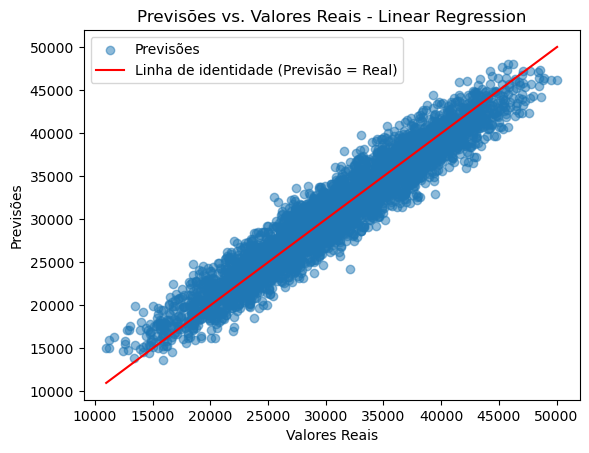

In [27]:
# Visualizar previsões vs. valores reais com linha de identidade
plt.scatter(y_test, y_pred, alpha=0.5, label="Previsões")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label="Linha de identidade (Previsão = Real)")
plt.xlabel('Valores Reais')
plt.ylabel('Previsões')
plt.title(f'Previsões vs. Valores Reais - {best_model_name}')
plt.legend()
plt.show()